<a href="https://colab.research.google.com/github/rs-delve/tti-explorer/blob/master/notebooks/tti-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTI Explorer

#### `tti_explorer` is a library for simulating infection spread. This library is built to explore the impact of various test-trace-isolate strategies and social distancing measures on the spread of COVID-19 in the UK. 

This notebook is an introduction to the functionality offered by `tti-explorer`. 

In [1]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

Cloning into 'tti-explorer'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2667 (delta 396), reused 405 (delta 277), pack-reused 2113
Receiving objects: 100% (2667/2667), 31.55 MiB | 3.72 MiB/s, done.
Resolving deltas: 100% (1909/1909), done.
/Users/milliemcquillin/Desktop/MPhil/ML & PW/project/tti-le48/tti-explorer-with-changes/notebooks/tti-explorer
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

In [3]:
def print_doc(func):
    print(func.__doc__)

Before we do anything, let's make a random state

In [4]:
rng = np.random.RandomState(0)

We will first do a short tour of the functionality, then show how this is put together to generate simulation results.

## Generate a case

The function we use for this is `simulate_case` in `case.py`

In [5]:
print_doc(simulate_case)

simulate_case

    Args:
        rng (np.random.RandomState): random number generator.
        p_under18 (float): Probability of case being under 18
        infection_proportions (dict): Probs of being symp covid neg, symp covid pos, asymp covid pos
                                      The only required key is 'dist', which contains list of the named probs, in that order.
        p_day_noticed_symptoms (np.array[float]): Distribution of day on which case notices
            their symptoms. (In our model this is same as reporting symptoms.)
            Conditional on being symptomatic.
        inf_profile (list[float]): Distribution of initial exposure of positive secondary cases
            relative to start of primary case's infectious period.

    Returns (Case): case with attributes populated.
    


We store our config values in `config.py`. You can retrieve them as follows

In [6]:
case_config = config.get_case_config("delve")
case_config.keys()

dict_keys(['p_under18', 'infection_proportions', 'p_day_noticed_symptoms', 'inf_profile'])

We use these parameters to simulate a case

In [7]:
primary_case = simulate_case(rng, **case_config)
print_doc(primary_case)

Case(under18:bool, covid:bool, symptomatic:bool, day_noticed_symptoms:int, inf_profile:list)


Returned is a `case.Case` with stochastically generated attributes.

### Deeper: Case attributes

Let's go through the simulated attributes of a `case.Case`. The attributes `.under18`, `.covid` and `.symptomatic` are `bool` types indicating whether the generated `case.Case` is under 18, COVID positive and symptomatic respectively. All possible values of these attributes are possible apart from the combination `.covid = False` and `.symptomatic = False` (a configuration irrelevant for the purpose of simulating infection spread). The primary case we just simulated has the following attributes:

In [8]:
print(f'Under 18: {primary_case.under18}.')
print(f'COVID positive: {primary_case.covid}.')
print(f'Symptomatic: {primary_case.symptomatic}.')

Under 18: False.
COVID positive: False.
Symptomatic: True.


Each `case.Case` also has an attribute `.day_noticed_symptoms` of type `int`, indicating the number of days from start of infectiousness until the `case.Case` noticed the symptoms. If a `case.Case` is asymptomatic, the attribute `.day_noticed_symptoms` is set to `-1`.

In [9]:
print(f'primary_case noticed symptoms {primary_case.day_noticed_symptoms} days after start of infectiousness.')

primary_case noticed symptoms 3 days after start of infectiousness.


Finally, the attribute `.inf_profile` is a `list` describing the relative infectiousness of the case for each day of the infectious period. If `.covid = False` for a `case.Case`, this is `0` throughout.

In [10]:
print(f'inf_profile is: {primary_case.inf_profile}')

inf_profile is: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


As mentioned above, the configuration for simulating these attributes are stored in `config.py`. This includes the distributions used for sampling attributes. For instance, the attribute `.under18` is sampled from a Bernoulli distribution with probability `0.21`: 

In [11]:
print(f'Probability of case being under 18: {case_config["p_under18"]}')

Probability of case being under 18: 0.21


As another example, if `case.Case` is symptomatic, the attribute `.days_noticed_symptoms` is sampled from a categorical distribution over the set {0, 1, ..., 9} (since we model an infection period of ten days in this configuration) with probabilities:

In [12]:
print(f'Probability distribution of .day_noticed_symptoms: {case_config["p_day_noticed_symptoms"]}')

Probability distribution of .day_noticed_symptoms: [0, 0.25, 0.25, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0]


## Generate contacts
Social contacts are represented by `Contacts` and defined in `contacts.py`.

To simulate social contacts, we use the BBC Pandemic Dataset. This is stratified as over/under 18 to give different patterns of social contact depending on the age of the case. 

In [13]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

In [14]:
path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

Now that we have the data loaded, we use `EmpiricalContactsSimulator` to sample these tables for contacts of the primary case, then simulate their infection under a no measures scenario (i.e. no government intervention)

In [15]:
print_doc(EmpiricalContactsSimulator.__init__)

Simulate social contact using the BBC Pandemic dataset

            Each row in input arrays consists of three numbers,
            represeting number of contacts at: home, work, other

        Args:
            over18 (np.array[int], Nx3): Contact data for over 18s.
            under18 (np.array[int], Nx3): Contact data for under 18s.
            rng (np.random.RandomState): Random state.

        


In [16]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

We can now use the callable `simulate_contacts` to simulate social contacts of the primary case

In [17]:
print_doc(simulate_contacts.__call__)

Generate a social contact for the given case.

        A row from the table corresponding to the age of the `case` is sampled
        uniformly at random. A contact is generated with daily contacts as
        given by that row. These contacts are infected at random with attack rates
        given by the SARs and whether or not the `case` is symptomatic. If the
        `case` is COVID negative, then no contacts are infected.

        Args:
            case (Case): Primary case.
            home_sar (float): Secondary attack rate for household contacts.
                              (Marginal probability of infection over the whole simulation)
            work_sar (float): Secondary attack rate for contacts in the work category.
            other_sar (float): Secondary attack rate for contacts in the other category.
            asymp_factor (float): Factor by which to multiply the probabilty of secondary
                                  infection if `case` is asymptomatic COVID positive

To do this we need some more parameters, which we also load from `config.py`. The user can, of course, specify this themselves if they would like.

In [18]:
contacts_config = config.get_contacts_config("delve")

In [19]:
contacts_config.keys()

dict_keys(['home_sar', 'work_sar', 'other_sar', 'period', 'asymp_factor'])

We now do the same as we did with when simulating a primary case.

In [20]:
social_contacts = simulate_contacts(primary_case, **contacts_config)
print_doc(social_contacts)

Contacts(n_daily:dict, home:<built-in function array>, work:<built-in function array>, other:<built-in function array>)


### Deeper: Contacts attributes

Let's examine the attributes of `social_contacts`, which is an instance of `contacts.Contacts`. Note that `social_contacts` is simulated above by calling `simulate_contacts` which takes `primary_case` as in argument, so contact generation of course depends on the case simulated first. 

The first attribute to note is `.n_daily`, which is a `dict` containing the average number of daily contacts (split into three categories) of the case. This is simulated by sampling one row of the tables `over18` or `under18` depending on the value of `primary_case.under18`. In the case of `primary_case`, we can look at `social_contacts.n_daily`:

In [21]:
print(f'Average number of daily contacts for primary_case:')
print(f'Home: {social_contacts.n_daily["home"]}')
print(f'Work: {social_contacts.n_daily["work"]}')
print(f'Other: {social_contacts.n_daily["other"]}')

Average number of daily contacts for primary_case:
Home: 7
Work: 3
Other: 4


The three remaining attributes `.home`, `.work` and `.other` are arrays containing information about each contact made by the case, with one row per contact. More specifically, for each contact, the row contains the first day (always measured relative to the start of infectiousness) of encounter between the case and contact and, if transmission occurred, then the day of transmission. 

Also, recall that home contacts are assumed to repeat every day of the infectious period, whereas work/other contacts are new for each day. This means the lengths of the arrays `.work` and `.other` are `10 * .n_daily['work']` and `10 * .n_daily['other']` respectively (recalling the infection period is assumed to last ten days, a parameter set in `contacts_config['period']`). Whereas, the length of the `.home` array is just `.n_daily['home']`.

In [22]:
print(f'Lengths of .home, .work and .other attributes:')
print(f'Home: {len(social_contacts.home)}')
print(f'Work: {len(social_contacts.work)}')
print(f'Other: {len(social_contacts.other)}')

Lengths of .home, .work and .other attributes:
Home: 7
Work: 30
Other: 40


Digging further into the array, each row contains two integers. The first integer indicates the day of transmission, which is set to `-1` if no transmission occurred. The second integer contains the day of first encounter. So for instance, looking at one of the home contacts, we see transmission didn't occur and the day of first encounter is `0`, i.e. the first day of the infection period:

In [23]:
print(social_contacts.home[0])

[-1  0]


Looking at the first six work contacts, we see none of them were infected either. This is consistent with the fact that `primary_case.covid = False` so no transmission can occur in this case.

In [24]:
print(social_contacts.work[:6])

[[-1  0]
 [-1  0]
 [-1  0]
 [-1  1]
 [-1  1]
 [-1  1]]


In simulations where `case.Case` is COVID positive, each contact may get infected and the probability of getting infected depends on parameters such as the secondary attack rates (SARs), all of which are set in `contacts_config`. For details on the precise simulation procedure used to generate `contacts.Contacts`, see either Appendix A of the report or the `__call__` method of `EmpiricalContactsSimulator`.

## TTI Strategies

All of the information about the primary case's infection and how they infect their social contacts (under no government intervention) is now contained in `primary_case` and `social_contacts`.

Now we run a simulation, which works as follows. We start by generating a large number of cases, each with associated contacts. Given a particular strategy (e.g. test-based TTI with NPI of stringency level S3), each case is passed through the strategy, which computes various metrics for the case. For example, it computes the number of secondary cases due to primary case (reproduction number) and the number of tests required. We then collect the results for each case and average them, returning the final evaluation of the strategy.

## Running a Simulation

In [29]:
from tti_explorer.strategies import TTIFlowModel

import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors as mcolors
from matplotlib import cm
import numpy as np
import GPy
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
import teaching_plots as plot
import mlai
import pandas as pd

We will analyse the `S3_test_based_TTI` strategy from our report. For clarity, we will show the whole process.

First get the configurations:

In [46]:
name = 'S3_test_based_TTI'

case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", name)[name]

print(case_config)
print('------------------------------------------------')
print(contacts_config)
print('------------------------------------------------')
print(policy_config)
print('------------------------------------------------')

{'p_under18': 0.21, 'infection_proportions': {'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 'nppl': 120}, 'p_day_noticed_symptoms': [0, 0.25, 0.25, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0], 'inf_profile': [0.046966101377360424, 0.15602255610429985, 0.19829974712514023, 0.18356485224565827, 0.14541407040442172, 0.10500447388376151, 0.07130993362939089, 0.04635772205156416, 0.029167894888682697, 0.017892648289720214]}
------------------------------------------------
{'home_sar': 0.3, 'work_sar': 0.045, 'other_sar': 0.045, 'period': 10, 'asymp_factor': 0.5}
------------------------------------------------
{'isolate_individual_on_symptoms': True, 'isolate_individual_on_positive': True, 'isolate_household_on_symptoms': True, 'isolate_household_on_positive': True, 'isolate_contacts_on_symptoms': False, 'isolate_contacts_on_positive': True, 'test_contacts_on_positive': False, 'do_symptom_testing': True, 'do_manual_tracing': True, 'do_app_tracing': True, 'fractional_infections': True, 

In [48]:
def update_policy_config(app_uptake, pol_compl):
    policy_config['app_cov'] = app_uptake
    policy_config['compliance'] = pol_compl
    return policy_config

policy_config = update_policy_config(0.5, 0.05)

In [49]:
# Separating this because it is built from the ammended policy_config

factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

print('------------------------------------------------')
print(factor_config)
print('------------------------------------------------')
print(strategy_config)
print('------------------------------------------------')

------------------------------------------------
{'app_cov': 0.5, 'compliance': 0.05, 'go_to_school_prob': 0.5, 'wfh_prob': 0.45}
------------------------------------------------
{'isolate_individual_on_symptoms': True, 'isolate_individual_on_positive': True, 'isolate_household_on_symptoms': True, 'isolate_household_on_positive': True, 'isolate_contacts_on_symptoms': False, 'isolate_contacts_on_positive': True, 'test_contacts_on_positive': False, 'do_symptom_testing': True, 'do_manual_tracing': True, 'do_app_tracing': True, 'fractional_infections': True, 'testing_delay': 2, 'app_trace_delay': 0, 'manual_trace_delay': 1, 'manual_home_trace_prob': 1.0, 'manual_work_trace_prob': 1.0, 'manual_othr_trace_prob': 1.0, 'met_before_w': 0.79, 'met_before_s': 0.9, 'met_before_o': 0.9, 'max_contacts': 10, 'quarantine_length': 14, 'latent_period': 3, 'app_cov': 0.5, 'compliance': 0.05}
------------------------------------------------


Set a random state:

In [33]:
rng = np.random.RandomState(42)

Make contact simulator:

In [34]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

Make the TTI Model:

In [35]:
tti_model = TTIFlowModel(rng, **strategy_config)

Generate cases, contacts and run simulation:

In [36]:
# init_vals = [[0.2, 0.3],[0.4, 0.3],[0.7, 0.7],[0.4, 0.45],[0.6, 0.1]]
# init_x = []
# for vals in init_vals:

#     policy_config = update_policy_config(vals[0], vals[1])
#     factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
#     strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
#     rng = np.random.RandomState(42)
#     simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
#     tti_model = TTIFlowModel(rng, **strategy_config)
#     n_cases = 10000
#     outputs = list()
#     temp =[]
#     for _ in trange(n_cases):
#         case = simulate_case(rng, **case_config)
#         case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
#         contacts = simulate_contacts(case, **contacts_config)
#         res = tti_model(case, contacts, case_factors)
#         outputs.append(res)
#         if res["Effective R"] >= 0:
#             temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
#     init_x.append(np.mean(temp))
#     to_show = [
#         RETURN_KEYS.base_r,
#         RETURN_KEYS.reduced_r,
#         RETURN_KEYS.man_trace,
#         RETURN_KEYS.app_trace,
#         RETURN_KEYS.tests
#     ]




Collate and average results across the cases simulated:

In [37]:
# This cell is mosltly just formatting results...
to_show = [
    RETURN_KEYS.base_r,
    RETURN_KEYS.reduced_r,
    RETURN_KEYS.man_trace,
    RETURN_KEYS.app_trace,
    RETURN_KEYS.tests
]

# scale factor to turn simulation numbers into UK population numbers
nppl = case_config['infection_proportions']['nppl']
scales = [1, 1, nppl, nppl, nppl]

results = pd.DataFrame(
    outputs
).mean(
    0
).loc[
    to_show
].mul(
    scales
).to_frame(
    name=f"Simulation results: {name.replace('_', ' ')}"
).rename(
    index=lambda x: x + " (k per day)" if x.startswith("#") else x
)

results.round(1)

NameError: name 'outputs' is not defined

In [38]:
"""
Runs TTI simulator as many times as the different input initialisations.
The main reason we need this is to put in to EmuKit for the Experimental
Design Loop.

Args:
    pol_configs (list): Inputs are [app_cov, compliance]

Returns:
    effective_rs (np.expand_dims(np.array(to_return), 1)): For every simulation run, return
    the effective r, as was plotted form Bryn and Andrei previously.

"""

def run_tti_sim(pol_configs):
    to_return=[]
    for vals in pol_configs:
        policy_config = update_policy_config(vals[0], vals[1])
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
        rng = np.random.RandomState(42)
        simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
        tti_model = TTIFlowModel(rng, **strategy_config)
        n_cases = 10000
        outputs = list()
        temp =[]
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
        to_return.append(np.mean(temp))
    return np.expand_dims(np.array(to_return), 1)




In [39]:
variable_domain = [0.05,1] # Set variables range. Since we are dealing with percentages (app_cov, compliance)
# [0.05, 1] should do.
initial_samples = 5 # number of random runs to perform before starting experimental design 
space = ParameterSpace(
          [ContinuousParameter('app_cov', *variable_domain), 
           ContinuousParameter('compliance', *variable_domain)]) # init param space for experimental design
design = RandomDesign(space)
x = design.get_samples(initial_samples) # get 5 random combinations of initialisations
y = run_tti_sim(x) # obtain corresponding effective_rs

In [40]:
# Fitting emulator to data, x: (app_cov, compliance), y: effective_r
kern_eq = GPy.kern.RBF(input_dim=2, ARD = True)
kern_bias = GPy.kern.Bias(input_dim=2)
kern = kern_eq + kern_bias
model_gpy = GPRegression(x,y, kern)
model_gpy.kern.variance = 1**2
model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy) 
model_emukit.optimize() # optimise (max log-lik)
display(model_gpy)



Optimization restart 1/1, f = -2.173589890602443


GP_regression.,value,constraints,priors
sum.rbf.variance,8.075814053069132,+ve,
sum.rbf.lengthscale,"(2,)",+ve,
sum.bias.variance,2.537622514595376,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [41]:
# Initialise experimental design loop. Using integrated variance as acquisition
# to "query" the input space aiming to reduce uncertainty over the func we're approx. i.e. effective_r
num_of_loops = 10
integrated_variance = IntegratedVarianceReduction(space=space, model=model_emukit)
ed = ExperimentalDesignLoop(space=space, model=model_emukit, acquisition = integrated_variance)
ed.run_loop(run_tti_sim, 2)

Optimization restart 1/1, f = -2.173589890602443



Optimization restart 1/1, f = -3.8814645525032443



Optimization restart 1/1, f = -6.473976943066747


main_effects:  {'app_cov': array([-0.00365172]), 'compliance': array([0.99229499])}
total_effects:  {'app_cov': array([0.01494018]), 'compliance': array([1.0139104])}


 ../mlai.py:15: MatplotlibDeprecationWarning:savefig() got unexpected keyword argument "directory" which is no longer supported as of 3.3 and will become an error two minor releases later


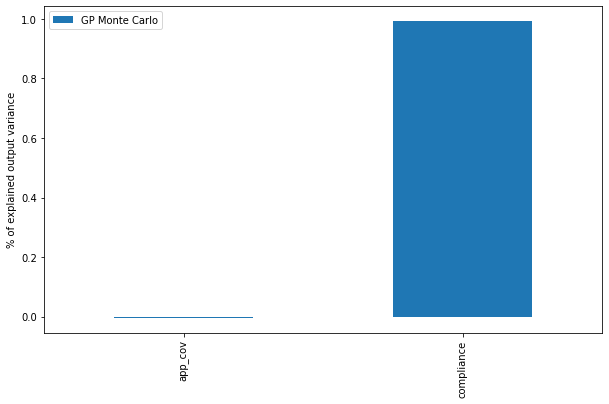

In [42]:
# Plot Main Effects

num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)
print("main_effects: ", main_effects_gp)
print("total_effects: ", total_effects_gp)


fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

mlai.write_figure(filename='first-order-sobol-indices-gp-catapult.svg', directory='./uq')

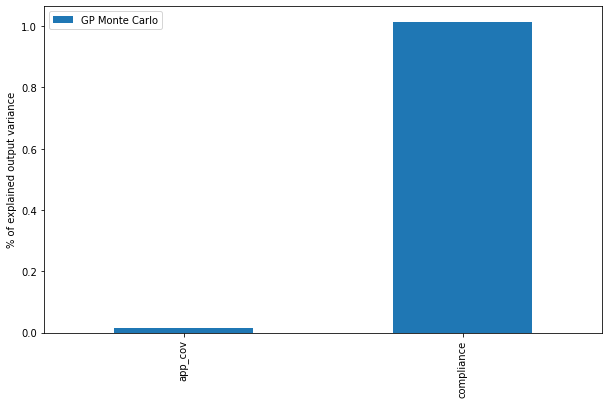

In [43]:
# Plot Total Effects

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

mlai.write_figure(filename='total-effects-sobol-indices-gp-catapult.svg', directory='./uq')

(100, 100)
(100, 100)
(100, 100)


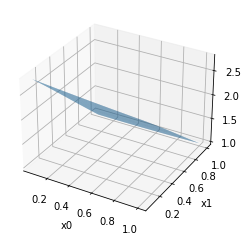

In [44]:
app_cov_eval = np.linspace(0.05, 1, 100)
app_com_eval = np.linspace(0.05, 1, 100)
points=[]
for i in app_cov_eval:
    for j in app_com_eval:
        points.append([i, j])
points = np.asarray(points)

X = points[:,0].reshape((100,100))
Y = points[:,1].reshape((100,100))
Z, _ = model_gpy.predict(points)
Z = Z.reshape((100,100))

print(X.shape)
print(Y.shape)
print(Z.shape)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.7)
# ax.scatter(x[:,0], x[:,1], y, color='red', alpha=0.99)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
plt.show()